# Addressing Training Difficulties

Some of the MRLFADS regions train better than others. Upon visual inspection, it seems that neurons with lower firing rate train less well, possibily due to the low log-likelihood penalty (since if spiking is sparse, it doesn't cost much to not predict it). To see if this is true, I calculated the correlation between the predicted firing rates of the model with a gaussian-filter-smoothed version of the data. Ideally, they should be somewhat similar to the other. This correlation value is then plotted against the average firing rate of the neuron across batches and time, and is shown in the figure below:

In [1]:
%matplotlib inline
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from IPython.display import Image, display, HTML, clear_output

clear_output()

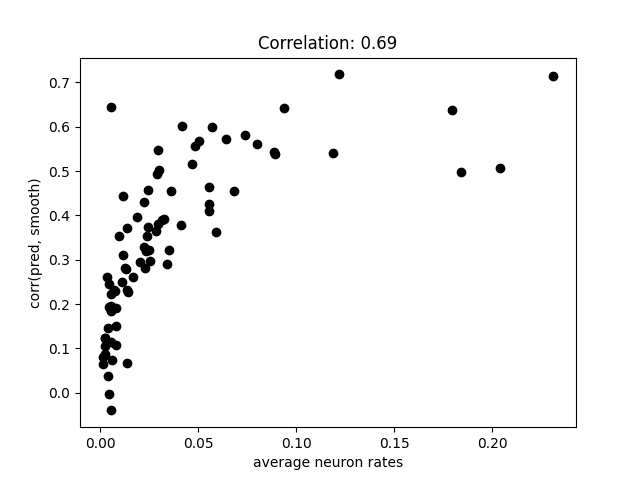

In [3]:
image = Image("../graphs/training_difficulty.png", width=650)
display(image)

This result suggests that there may indeed be some relationship between the ease of training and neurons' average firing rates. To address this, I used a Zero Inflated Poisson distribution for the model output instead of just a Poisson output. This is:

$p(k) = \pi + (1-\pi) Poiss(k; \lambda)$

This allows the distribution to "offload" some of the zeros to the parameter $\pi$, and allow $\lambda$ to capture the non-zero terms better. This implementation did allow the model to perform better, and even "fixed" some of the channels that kept not being able to move on from pass through.

However, as the model keeps training, $\pi$ eventually becomes too large, and $k$ is inflated along with it, leading to an unrealistic result. To see why that may be, we do the following simulation:

In [53]:
def nll(target, pi, mu):
    """
    sanity check: https://math.stackexchange.com/questions/2761563/maximum-likelihood-estimation-for-zero-inflated-poisson-distribution
    """
    lam = np.log(mu)
    l0 = (target == 0) * np.log(pi + (1-pi) * np.exp(-np.exp(lam)))
    l1 = (target > 0) * (np.log(1-pi) - np.exp(lam)) + target * lam
    return - (l0 + l1)

class ZiPoisson:
    def __init__(self, pi, lam):
        self.pi = pi
        self.lam = lam
        
    def rsample(self, N):
        x = np.random.uniform(0, 1, size=N)
        return (x > self.pi) * np.random.poisson(self.lam, size=N)
        
    def nll(self, target):
        return nll(target, self.pi, self.lam)

Here, I set up a ZI-Poisson distribution with parameters $\pi^*=0.5$, $\lambda^*=0.02$, and got $N=10000$ samples from it. This is visually as sparse as some of the neurons get. I then calculated the negative loglikelihood values (smaller the better) for various $\pi$, $\lambda$ using these samples.

In [116]:
np.random.seed(42)

N = 10000
pi_true = 0.5
lam_true = 0.02
dist = ZiPoisson(pi_true, lam_true)
sample = dist.rsample(N)
nll_true = dist.nll(sample)

expon = np.linspace(-4, -0.7, 10)
lam_grid = 10 ** expon
pi_grid = np.linspace(0, 0.9, 10)
nll_test = [[nll(sample, pi_test, lam_test).mean() for pi_test in pi_grid] for lam_test in lam_grid]

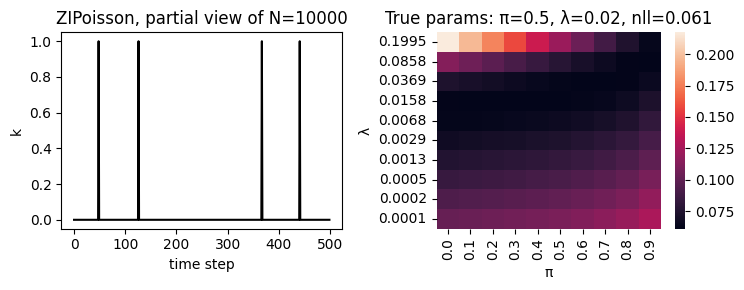

The nll of the true parameters is 0.06103830545258381, and the minimum of this heatmap is 0.060959102961375744.
The corresponding parameter for the minimum nll is π=0.7 and λ=0.0369.


In [117]:
fig = plt.figure(figsize=(3*2.5, 3*1))
ax1 = fig.add_subplot(121)
ax1.plot(sample[:500], "k")
ax1.set_xlabel("time step")
ax1.set_ylabel("k")
ax1.set_title(f"ZIPoisson, partial view of N={N}")
ax2 = fig.add_subplot(122)
sns.heatmap(nll_test,
            xticklabels=[round(g,1) for g in pi_grid],
            yticklabels=[round(g,4) for g in lam_grid],
            ax=ax2) 
ax2.invert_yaxis()
ax2.set_xlabel("\u03C0")
ax2.set_ylabel("\u03BB")
ax2.set_title(f"True params: \u03C0={pi_true}, \u03BB={lam_true}, nll={round(nll_true.mean(), 3)}")
plt.tight_layout()
plt.show()

(idx_lam, idx_pi) = np.dstack(np.unravel_index(np.argsort(np.array(nll_test).ravel()), (10, 10)))[0][0]
print(f"The nll of the true parameters is {nll_true.mean()}, and the minimum of this heatmap is {min(np.array(nll_test).flatten())}.")
print(f"The corresponding parameter for the minimum nll is \u03C0={round(pi_grid[idx_pi],1)} and \u03BB={round(lam_grid[idx_lam],4)}.")

We see that the true parameter does not necessarily lead to the lowest nll. In fact, the parameter with lowest nll often has either deflated $\pi$ and $\lambda$, or inflated $\pi$ and $\lambda$, as is observed during model training. On a closer look, we can see that the loss landscape actually has a double-well structure, corresponding to the deflated or inflated cases (not shown).

This flat (and potentially double-well) loss landscape, coupled with finite sampling, might be the cause of the model learning an incorrect parameter. In fact, it is difficult to find the minimum even when using ``scipy.optimize`` that is initialized to the correct parameters, especially with low number of samples.

In [155]:
N = 500
pi_true = 0.5
lam_true = 0.02
dist = ZiPoisson(pi_true, lam_true)
sample = dist.rsample(N)

def obj_func(pms): return nll(sample, *pms).mean()
minimize(obj_func, x0=(pi_true, lam_true), bounds=((0, 1), (0, 1)))

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 0.05605595101804938
        x: [ 6.607e-02  1.058e-02]
      nit: 15
      jac: [ 1.827e-04 -1.103e-02]
     nfev: 84
     njev: 28
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>

If the loss landscape truly has a double-well structure, then there is no room for improvement -- that is, due to the structure of the data, the true parameters simply aren't the ones that give minimum loss. If the double-well structure is due to finite sampling, then there is room for improvement, but only in the sense that more data will help. With limited amount of data, there is not much the model can do.

One way to address this issue would be to stop $\pi$ from evolving when it reaches a certain criteria (e.g. when the correlation with the smoothed firing rates stop increasing). However, this is a bit of an arbritarily imposed criterion.